<a href="https://colab.research.google.com/github/thunderingluck/6s061/blob/main/redundancy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train size: 56 Test size: 24
Baseline test accuracy: 1.0


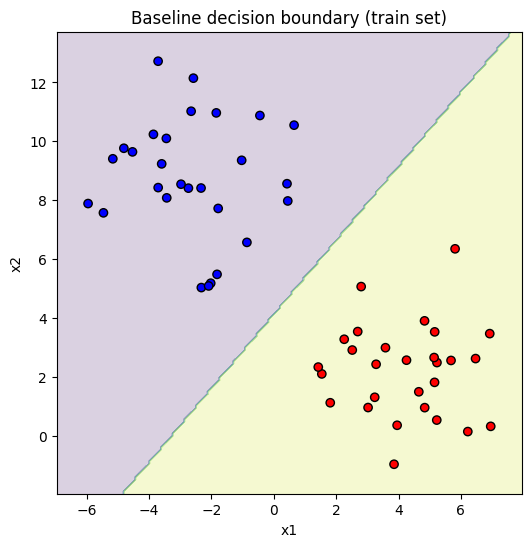

Computing leave-one-out importance for each training point...
Done computing importance.
Importance stats: min = 3.120451863784221e-06 max = 0.0020548915885989423


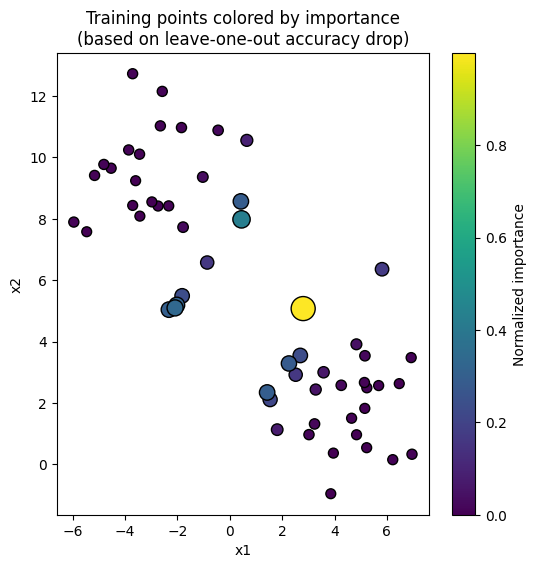

Top 10 most important point indices and their importance:
Rank 1: index 34, importance 0.0021
Rank 2: index 13, importance 0.0009
Rank 3: index 51, importance 0.0007
Rank 4: index 45, importance 0.0006
Rank 5: index 47, importance 0.0006
Rank 6: index 38, importance 0.0006
Rank 7: index 21, importance 0.0006
Rank 8: index 44, importance 0.0006
Rank 9: index 11, importance 0.0005
Rank 10: index 27, importance 0.0005
K =   5 | test acc = 1.000
K =  10 | test acc = 1.000
K =  20 | test acc = 1.000
K =  40 | test acc = 1.000
K =  56 | test acc = 1.000

Using only top 20 points, test accuracy = 1.000


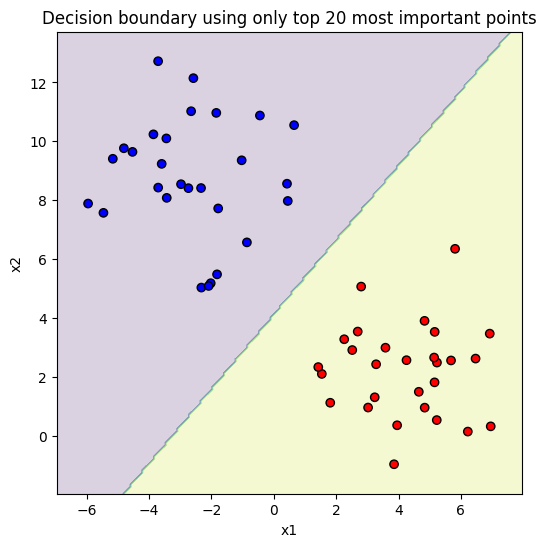

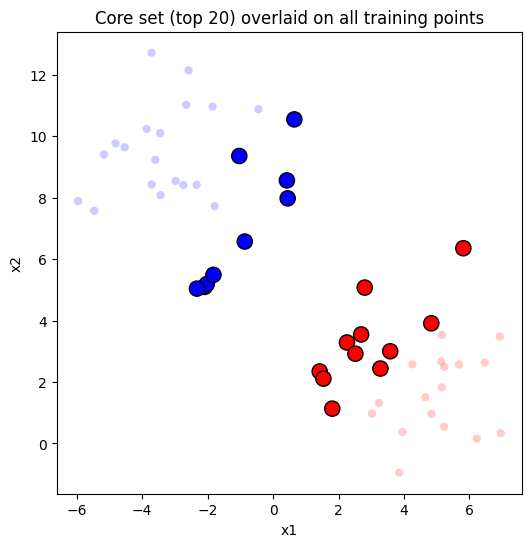


Done! You now have:
- Per-point importance scores (importance array)
- Visualizations of which points are essential vs redundant
- A 'core set' experiment showing how few points you can keep and still get good performance


In [ ]:
# ============================================
# Toy experiment: essential vs redundant data
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# For nicer plots in Colab
plt.rcParams["figure.figsize"] = (6, 6)

# -----------------------------
# 1. Generate a simple 2D dataset
# -----------------------------
# Two clusters, 2D, binary classification
X, y = make_blobs(
    n_samples=80,
    centers=2,
    n_features=2,
    cluster_std=2.0,
    random_state=42
)


# Split into train and test so we can evaluate generalization
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

# -----------------------------
# 2. Train a baseline model
# -----------------------------
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred_test = clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_test)
print("Baseline test accuracy:", baseline_acc)

# Function to visualize decision boundary
def plot_decision_boundary(model, X, y, title="Decision boundary"):
    # Create grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict on grid
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    # Plot
    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap="bwr")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

plot_decision_boundary(clf, X_train, y_train, "Baseline decision boundary (train set)")

# -----------------------------
# 3. Leave-one-out importance
# -----------------------------
# For each training point:
#   - remove it
#   - retrain the model
#   - measure drop in test accuracy
#   → importance = (baseline_acc - new_acc)

n_train = X_train.shape[0]
importance = np.zeros(n_train)

print("Computing leave-one-out importance for each training point...")
probs_baseline = clf.predict_proba(X_test)[:, 1]  # baseline probs for class 1

for i in range(n_train):
    # Remove point i from training data
    mask = np.ones(n_train, dtype=bool)
    mask[i] = False
    X_train_minus_i = X_train[mask]
    y_train_minus_i = y_train[mask]

    # Retrain model
    clf_i = LogisticRegression()
    clf_i.fit(X_train_minus_i, y_train_minus_i)

    # Compare predicted probabilities on the SAME test set
    probs_i = clf_i.predict_proba(X_test)[:, 1]
    importance[i] = np.mean(np.abs(probs_baseline - probs_i))  # average change in probs

print("Done computing importance.")
print("Importance stats: min =", importance.min(), "max =", importance.max())

# -----------------------------
# 4. Visualize importance on the train set
# -----------------------------
# We’ll use point size or color to show importance

# Normalize importance for visualization
imp_norm = (importance - importance.min()) / (importance.max() - importance.min() + 1e-8)
sizes = 50 + 250 * imp_norm  # point sizes

plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=imp_norm,
    s=sizes,
    cmap="viridis",
    edgecolor="k"
)
plt.colorbar(label="Normalized importance")
plt.title("Training points colored by importance\n(based on leave-one-out accuracy drop)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

# -----------------------------
# 5. Build a "core set"
# -----------------------------
# Sort training points by importance (descending)
sorted_indices = np.argsort(-importance)  # negative for descending
print("Top 10 most important point indices and their importance:")
for i in range(10):
    idx = sorted_indices[i]
    print(f"Rank {i+1}: index {idx}, importance {importance[idx]:.4f}")

# Try using only the top K important points as the "core set"
def train_on_core_set(K):
    core_indices = sorted_indices[:K]
    X_core = X_train[core_indices]
    y_core = y_train[core_indices]

    clf_core = LogisticRegression()
    clf_core.fit(X_core, y_core)

    y_pred_test_core = clf_core.predict(X_test)
    acc_core = accuracy_score(y_test, y_pred_test_core)
    return clf_core, acc_core, X_core, y_core

# Experiment with a few different K values
for K in [5, 10, 20, 40, len(X_train)]:
    clf_core, acc_core, X_core, y_core = train_on_core_set(K)
    print(f"K = {K:3d} | test acc = {acc_core:.3f}")

# Visualize decision boundary using only a small core set
K_visual = 20
clf_core_vis, acc_core_vis, X_core_vis, y_core_vis = train_on_core_set(K_visual)
print(f"\nUsing only top {K_visual} points, test accuracy = {acc_core_vis:.3f}")
plot_decision_boundary(
    clf_core_vis,
    X_train,
    y_train,
    title=f"Decision boundary using only top {K_visual} most important points"
)

# Also plot just the core points to see where they lie
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=0.2, cmap="bwr", edgecolor="none")
plt.scatter(
    X_core_vis[:, 0],
    X_core_vis[:, 1],
    c=y_core_vis,
    cmap="bwr",
    edgecolor="k",
    s=120,
    marker="o"
)
plt.title(f"Core set (top {K_visual}) overlaid on all training points")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

print("\nDone! You now have:")
print("- Per-point importance scores (importance array)")
print("- Visualizations of which points are essential vs redundant")
print("- A 'core set' experiment showing how few points you can keep and still get good performance")
